In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
train_data = np.load('FireEvac_train_set.npy')
test_data = np.load('FireEvac_test_set.npy')
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)

[132.28261  74.16715]
[34.592216 24.910944]
[132.28261  74.16715]
[34.592216 24.910944]


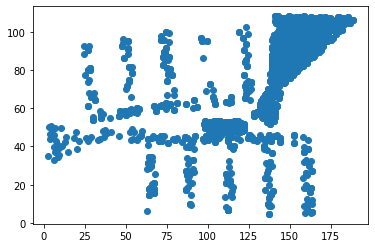

In [9]:
plt.scatter(train_data[:,0], train_data[:,1])

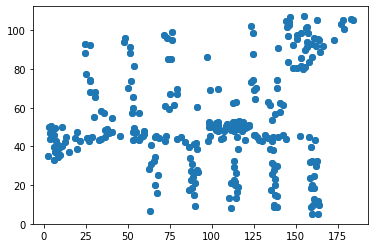

In [10]:
plt.scatter(test_data[:,0], test_data[:,1])

In [226]:
class VAE(nn.Module):
    def __init__(self, obs_dim, latent_dim, hidden_dim=100):
        """Initialize the VAE model.
        
        :args:
            obs_dim: Dimension of the observed data x, int
            latent_dim: Dimension of the latent variable z, int
            hidden_dim: Hidden dimension of the encoder/decoder networks, int
        """
        super().__init__()
        self.latent_dim = latent_dim
        # Trainable layers of the encoder
        self.linear1 = nn.Linear(obs_dim, hidden_dim)
        self.linear21 = nn.Linear(hidden_dim, latent_dim)
        self.linear22 = nn.Linear(hidden_dim, latent_dim)
        # Trainable layers of the decoder
        self.linear3 = nn.Linear(latent_dim, hidden_dim)
        #self.linear4 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, obs_dim)
    
    def encoder(self, x):
        """Obtain the parameters of q(z) for a batch of data points.
        
        :args:
            x: Batch of data points, shape [batch_size, obs_dim]
        
        :returns:
            mu: Means of q(z), shape [batch_size, latent_dim]
            logsigma: Log-sigmas of q(z), shape [batch_size, latent_dim]
        """
        h = torch.relu(self.linear1(x))
        return self.linear21(h), self.linear22(h)

    
    def sample_with_reparam(self, mu, logsigma):
        """Draw sample from q(z) with reparametrization.
        
        We draw a single sample z_i for each data point x_i.
        
        :args:
            mu: Means of q(z) for the batch, shape [batch_size, latent_dim]
            logsigma: Log-sigmas of q(z) for the batch, shape [batch_size, latent_dim]
        
        :Returns:
            z: Latent variables samples from q(z), shape [batch_size, latent_dim]
        """
        epsilon = torch.empty_like(mu).normal_(0., 1.)
        return epsilon * logsigma.exp() + mu

    
    def decoder(self, z):
        """Convert sampled latent variables z into observations x.
        
        :args:
            z: Sampled latent variables, shape [batch_size, latent_dim]
        
        :returns:
            theta: Parameters of the conditional likelihood, shape [batch_size, obs_dim]
        """
        return torch.relu(self.linear4(torch.relu(self.linear3(z))))

    
    def kl_divergence(self, mu, logsigma):
        """Compute KL divergence KL(q_i(z)||p(z)) for each q_i in the batch.
        
        :args:
            mu: Means of the q_i distributions, shape [batch_size, latent_dim]
            logsigma: Logarithm of standard deviations of the q_i distributions,
                      shape [batch_size, latent_dim]
        
        :returns:
            kl: KL divergence for each of the q_i distributions, shape [batch_size]
        """

        return 0.5 * (mu.pow(2) + (2 * logsigma).exp() - 2 * logsigma - 1).sum(-1)

    
    def elbo(self, x):
        """Estimate the ELBO for the mini-batch of data.
        
        :args:
            x: Mini-batch of the observations, shape [batch_size, obs_dim]
        
        :returns:
            elbo_mc: MC estimate of ELBO for each sample in the mini-batch, shape [batch_size]
        """
        mu, logsigma = self.encoder(x)
        z = self.sample_with_reparam(mu, logsigma)
        theta = self.decoder(z)
        log_obs_prob = torch.distributions.multivariate_normal.MultivariateNormal(theta, torch.eye(2)).log_prob(x)
        kl = self.kl_divergence(mu, logsigma)
        return log_obs_prob - kl
        

In [227]:
# Would be possible to use softplus but by considering it as logstd we are always positive
obs_dim = 2 
latent_dim = 2# Size of the latent variable z
hidden_dim = 256  # Size of the hidden layer in the encoder / decoder

vae = VAE(obs_dim, latent_dim, hidden_dim)
lr = 1e-3
opt = torch.optim.Adam(vae.parameters(), lr=lr)

In [228]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size, shuffle=True
    )
test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=600, shuffle=True
    )

In [229]:
max_epochs = 200
display_step = 100
for epoch in range(max_epochs):
    print(f'Epoch {epoch}')
    for ix, batch in enumerate(train_loader):
        x = batch
        x = x.view(x.shape[0], obs_dim)  # we flatten the image into 1D array
        opt.zero_grad()
        # We want to maximize the ELBO, so we minimize the negative ELBO
        loss = -vae.elbo(x).mean(-1)
        loss.backward()
        opt.step()
        for _, batch_ in enumerate(test_loader):
            loss_ = -vae.elbo(batch_).mean(-1)
            
        if ix % display_step == 0:
            print(f'  loss = {loss_.item():.9f}')

        
        

Epoch 0
  loss = 7659.113281250
Epoch 1
  loss = 4603.271484375
Epoch 2
  loss = 2833.464111328
Epoch 3
  loss = 2361.791748047
Epoch 4
  loss = 2171.585205078
Epoch 5
  loss = 2057.191162109
Epoch 6
  loss = 1982.451049805
Epoch 7
  loss = 1924.843139648
Epoch 8
  loss = 1678.833496094
Epoch 9
  loss = 1298.553588867
Epoch 10
  loss = 1025.590576172
Epoch 11
  loss = 850.469482422
Epoch 12
  loss = 724.710266113
Epoch 13
  loss = 640.921875000
Epoch 14
  loss = 587.372192383
Epoch 15
  loss = 528.631286621
Epoch 16
  loss = 489.323608398
Epoch 17
  loss = 454.924072266
Epoch 18
  loss = 425.813812256
Epoch 19
  loss = 402.100341797
Epoch 20
  loss = 381.869415283
Epoch 21
  loss = 363.786285400
Epoch 22
  loss = 347.941009521
Epoch 23
  loss = 333.074737549
Epoch 24
  loss = 320.040893555
Epoch 25
  loss = 307.963348389
Epoch 26
  loss = 297.255981445
Epoch 27
  loss = 286.892761230
Epoch 28
  loss = 276.549285889
Epoch 29
  loss = 267.783905029
Epoch 30
  loss = 259.089538574
Epoch 3

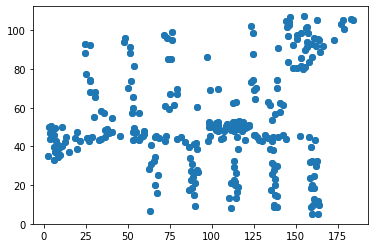

VAE reconstruction:


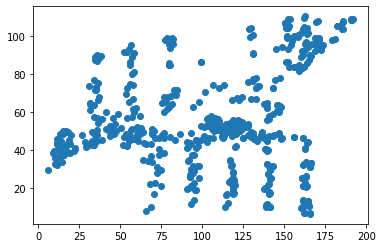

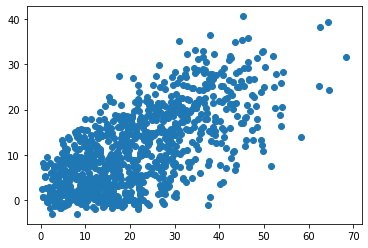

In [230]:
plt.scatter(test_data[:,0], test_data[:,1])
plt.show()
# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
images = visualise_output(test_loader, vae)
plt.scatter(images[:,0], images[:,1])
plt.show()
#print("VAE samples:")
x = np.asarray(sample(1000))
plt.scatter(x[:,0], x[:,1])
plt.show()
num_crit = 0
samples = [1000, 1500, 2000, 2500, 3000, 3500, 4000]
for s in samples:
    x = sample(s).numpy()
    for coord in x:
        if 130<coord[0]<150 and 50< coord[1]<70:
            num_crit += 1
    if num_crit > 100:
        print("critical number!")
        print(s)
        break

In [204]:
# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed

def visualise_output(x, model):
    model.eval()
    with torch.no_grad():
        for ix, batch in enumerate(x):
            latent_mu, latent_logvar = model.encoder(batch)
            latent = model.sample_with_reparam(latent_mu, latent_logvar)
            theta = model.decoder(latent)            
        return theta
    
    
def sample(num_samples):
        z = torch.empty(num_samples, latent_dim).normal_()
        theta = vae.decoder(z)
        samples = torch.empty(num_samples, latent_dim)
        for i in range(num_samples):
            dist = torch.distributions.multivariate_normal.MultivariateNormal(theta[i,:], torch.eye(2))
            samples[i,:] = dist.sample()
        return samples

In [ ]:
import json
import copy

def generate_default_pedestrian():
    """
    Generates an initialized pedestrian object to be added to the scenario json
    
    :returns: 
        return: an initialized pedestrian as a dictionary
    """
    false = False
    null = None
    return {
        "attributes": {
            "id": 8,
            "radius": 0.2,
            "densityDependentSpeed": false,
            "speedDistributionMean": 1.34,
            "speedDistributionStandardDeviation": 0.26,
            "minimumSpeed": 0.5,
            "maximumSpeed": 2.2,
            "acceleration": 2.0,
            "footstepHistorySize": 4,
            "searchRadius": 1.0,
            "walkingDirectionCalculation": "BY_TARGET_CENTER",
            "walkingDirectionSameIfAngleLessOrEqual": 45.0
        },
        "source": null,
        "targetIds": [1],
        "nextTargetListIndex": 0,
        "isCurrentTargetAnAgent": false,
        "position": {
            "x": 5.7,
            "y": 1.2
        },
        "velocity": {
            "x": 0.0,
            "y": 0.0
        },
        "freeFlowSpeed": 1.6239471913829229,
        "followers": [],
        "idAsTarget": -1,
        "isChild": false,
        "isLikelyInjured": false,
        "psychologyStatus": {
            "mostImportantStimulus": null,
            "threatMemory": {
                "allThreats": [],
                "latestThreatUnhandled": false
            },
            "selfCategory": "TARGET_ORIENTED",
            "groupMembership": "OUT_GROUP",
            "knowledgeBase": {
                "knowledge": []
            }
        },
        "groupIds": [],
        "groupSizes": [],
        "trajectory": {
            "footSteps": []
        },
        "modelPedestrianMap": null,
        "type": "PEDESTRIAN"
    }

def add_pedestrians(json_file, num_pedestrians):
    coords = sample(num_pedestrians).detach().numpy()
    path_json = "MI_Building.scenario"
    
    with open(path_to_scenario, 'r') as myfile:
    data = myfile.read()
    for coord in coords:
        # parse file
        obj = json.loads(data)
        obj["name"] = obj["name"]+"_new"

        # calculate new x and y coordinates
        new_pedestrian_coord_y = coord[1]
        new_pedestrian_coord_x = coord[0]
        new_pedestrian = generate_default_pedestrian()

        # Find already used pedestrian Ids to avoid confusions
        ids = []
        for dynamicattr in obj["scenario"]["topography"]["dynamicElements"]:
            if dynamicattr["type"] == "PEDESTRIAN":
                ids.append(dynamicattr["attributes"]["id"])
        if len(ids) > 0:
          max_id = np.max(ids)
        else:
          max_id = 0
        # Find target id  
        targetid = obj["scenario"]["topography"]["sources"][0]["targetIds"]
        # Set new pedestrian's target id
        new_pedestrian["targetIds"] = targetid
        # Set new pedestrian's id
        new_pedestrian["attributes"]["id"] = int(max_id + 1)
        # Set new pedestrian's x and y coordinates
        new_pedestrian["position"]["x"] = new_pedestrian_coord_x
        new_pedestrian["position"]["y"] = new_pedestrian_coord_y
        # Add pedestrian to the scenario's dictionary
        obj["scenario"]["topography"]["dynamicElements"].append(new_pedestrian)

        # Save to a new json file
        with open(path_to_scenario.replace(".scenario","_new.scenario"), 'w') as outfile:
            json.dump(obj, outfile, indent=4)

